In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from matplotlib.colors import colorConverter, ListedColormap 

In [2]:
# 对于上面的fit可以这么扩展变成动态的
from sklearn.preprocessing import OneHotEncoder
def onehot(y,start,end):
    ohe = OneHotEncoder()
    a = np.linspace(start,end-1,end-start)
    b =np.reshape(a,[-1,1]).astype(np.int32)
    ohe.fit(b)
    c=ohe.transform(y).toarray()  
    return c

In [3]:
def generate(sample_size, num_classes, diff,regression=False):
    np.random.seed(10)
    mean = np.random.randn(2)
    cov = np.eye(2)  
    
    #len(diff)
    samples_per_class = int(sample_size/num_classes)

    X0 = np.random.multivariate_normal(mean, cov, samples_per_class)
    Y0 = np.zeros(samples_per_class)
    
    for ci, d in enumerate(diff):
        X1 = np.random.multivariate_normal(mean+d, cov, samples_per_class)
        Y1 = (ci+1)*np.ones(samples_per_class)
    
        X0 = np.concatenate((X0,X1))
        Y0 = np.concatenate((Y0,Y1))
        #print(X0, Y0)
    
    if regression==False: #one-hot  0 into the vector "1 0
        Y0 = np.reshape(Y0,[-1,1])        
        #print(Y0.astype(np.int32))
        Y0 = onehot(Y0.astype(np.int32),0,num_classes)
        #print(Y0)
    X, Y = shuffle(X0, Y0)
    #print(X, Y)
    return X,Y    

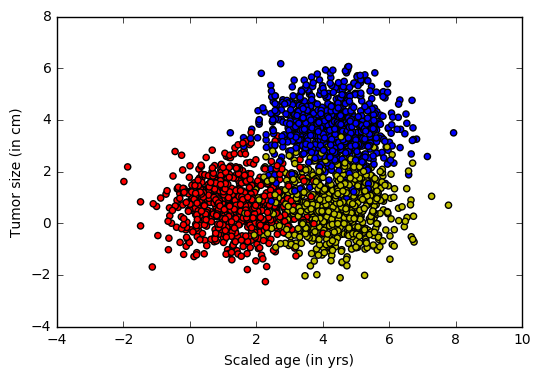

In [4]:
# 1.生成样本集
np.random.seed(10)
input_dim = 2
num_classes = 3
X, Y = generate(2000,num_classes,  [[3.0],[3.0,0]],False)
# 返回沿轴的最大值的索引。
aa = [np.argmax(l) for l in Y]
colors = ['r' if l == 0 else 'b' if l ==1 else 'y' for l in aa[:]]
# 将具体的点依照不同的颜色显示出来
plt.scatter(X[:,0], X[:,1], c=colors)
plt.xlabel("Scaled age (in yrs)")
plt.ylabel("Tumor size (in cm)")
plt.show()

In [5]:
# 2.构建网络结构
lab_dim = num_classes
# 定位占位符
input_features = tf.placeholder(tf.float32, [None, input_dim])
input_lables = tf.placeholder(tf.float32, [None, lab_dim])
# 定义学习参数
W = tf.Variable(tf.random_normal([input_dim, lab_dim]), name="weight")
b = tf.Variable(tf.zeros([lab_dim]), name="bias")
output = tf.matmul(input_features, W) + b

z = tf.nn.softmax(output)

# 按行找出最大索引
a1 = tf.argmax(tf.nn.softmax(output), axis=1)

b1 = tf.argmax(input_lables, axis=1)
# 两个数组相减，不为0的就是错误个数
err = tf.count_nonzero(a1-b1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=input_lables,logits=output)
# 对交叉熵取均值很有必要
loss = tf.reduce_mean(cross_entropy)

# 尽量用Adam算法的优化器，因其收敛快，会动态调节梯度
optimizer = tf.train.AdamOptimizer(0.04)
train = optimizer.minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



Epoch: 0001 cost= 0.742577493 err= 0.5716455696202529
Epoch: 0002 cost= 0.453475982 err= 0.1898734177215189
Epoch: 0003 cost= 0.372879982 err= 0.11797468354430382
Epoch: 0004 cost= 0.344329596 err= 0.10582278481012662
Epoch: 0005 cost= 0.333802879 err= 0.10227848101265827
Epoch: 0006 cost= 0.331050158 err= 0.10126582278481017
Epoch: 0007 cost= 0.332063675 err= 0.09772151898734184
Epoch: 0008 cost= 0.335014313 err= 0.09518987341772159
Epoch: 0009 cost= 0.338974863 err= 0.09518987341772159
Epoch: 0010 cost= 0.343438745 err= 0.09468354430379752
Epoch: 0011 cost= 0.348112911 err= 0.09316455696202537
Epoch: 0012 cost= 0.352821320 err= 0.09468354430379752
Epoch: 0013 cost= 0.357456028 err= 0.09316455696202537
Epoch: 0014 cost= 0.361950427 err= 0.09164556962025322
Epoch: 0015 cost= 0.366264611 err= 0.09265822784810132
Epoch: 0016 cost= 0.370375127 err= 0.09113924050632917
Epoch: 0017 cost= 0.374270171 err= 0.08962025316455702
Epoch: 0018 cost= 0.377945453 err= 0.08911392405063297
Epoch: 0019 

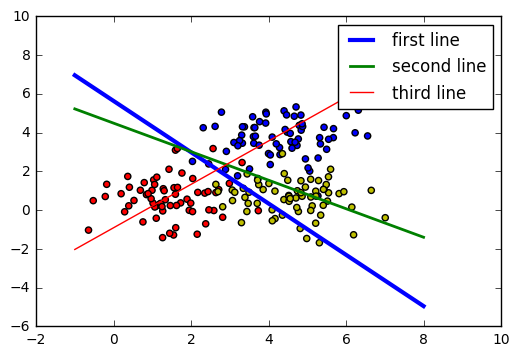

[[-1.68156    1.3040521  1.4129657]
 [-1.2703961  1.7713857 -1.2616552]] [ 7.1639824 -7.958726  -1.1438725]


D:\java_dev\Anaconda3.5\lib\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
D:\java_dev\Anaconda3.5\lib\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


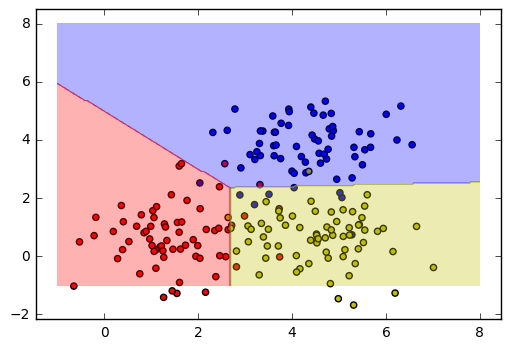

In [6]:
# 3.设置参数进行训练
maxEpochs = 50
minibatchSize = 25

# 启动session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(maxEpochs):
        sumerr = 0
        for i in range(np.int32(len(Y)/minibatchSize)):
            x1 = X[i*minibatchSize:(i+1)*minibatchSize,:]
            y1 = Y[i*minibatchSize:(i+1)*minibatchSize,:]
            
            _,lossval, outputval,errval = sess.run([train,loss,output,err], feed_dict={input_features: x1, input_lables:y1})
            sumerr =sumerr+(errval/minibatchSize)
            
        print ("Epoch:", '%04d' % (epoch+1), "cost=","{:.9f}".format(lossval),"err=",sumerr/(np.int32(len(Y)/minibatchSize)))
        


# 4.数据可视化
    train_X, train_Y = generate(200, num_classes, [[3.0], [3.0,0]], False)
    aa = [np.argmax(l) for l in train_Y]
    colors =['r' if l == 0 else 'b' if l==1 else 'y' for l in aa[:]]
    plt.scatter(train_X[:,0], train_X[:,1], c=colors)    
    
    x = np.linspace(-1,8,200) 
    
    y=-x*(sess.run(W)[0][0]/sess.run(W)[1][0])-sess.run(b)[0]/sess.run(W)[1][0]
    plt.plot(x,y, label='first line',lw=3)

    y=-x*(sess.run(W)[0][1]/sess.run(W)[1][1])-sess.run(b)[1]/sess.run(W)[1][1]
    plt.plot(x,y, label='second line',lw=2)

    y=-x*(sess.run(W)[0][2]/sess.run(W)[1][2])-sess.run(b)[2]/sess.run(W)[1][2]
    plt.plot(x,y, label='third line',lw=1)
    
    plt.legend()
    plt.show() 
    print(sess.run(W),sess.run(b))
    
    
# 5.模型可视化
    train_X, train_Y = generate(200,num_classes,  [[3.0],[3.0,0]],False)
    aa = [np.argmax(l) for l in train_Y]        
    colors =['r' if l == 0 else 'b' if l==1 else 'y' for l in aa[:]]
    plt.scatter(train_X[:,0], train_X[:,1], c=colors)    
    
    nb_of_xs = 200
    xs1 = np.linspace(-1, 8, num=nb_of_xs)
    xs2 = np.linspace(-1, 8, num=nb_of_xs)
    # 从坐标向量返回坐标矩阵。
    xx, yy = np.meshgrid(xs1, xs2) # 创建网络
    # 初始化和填充classification plane
    classification_plane = np.zeros((nb_of_xs, nb_of_xs))
    for i in range(nb_of_xs):
        for j in range(nb_of_xs):
            #classification_plane[i,j] = nn_predict(xx[i,j], yy[i,j])
            classification_plane[i,j] = sess.run(a1, feed_dict={input_features: [[ xx[i,j], yy[i,j] ]]} )
    
    
    # 创建color map 用于显示
    cmap = ListedColormap([
            colorConverter.to_rgba('r', alpha=0.30),
            colorConverter.to_rgba('b', alpha=0.30),
            colorConverter.to_rgba('y', alpha=0.30)])
    # 图示各个样本边界
    plt.contourf(xx, yy, classification_plane, cmap=cmap)
    plt.show()    
    